# Cyber Attacks Classification using Machine Learning


In [93]:
import os
import timeit
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, zero_one_loss
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
import seaborn as sns

In [94]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'


In [95]:
np.random.seed(1333)
dataset_root = 'Dataset'

train_file = os.path.join(dataset_root, 'Trainingfile.txt')
test_file = os.path.join(dataset_root, 'Testingfile.txt')

In [96]:
train_file

'Dataset\\Trainingfile.txt'

In [97]:
test_file

'Dataset\\Testingfile.txt'

In [98]:
# Original KDD dataset feature names obtained from


header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
                'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
                'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
                'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
                'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
                'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
                'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
                'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type',
                'occurance']

# Differentiating between nominal, binary, and numeric features

col_names = np.array(header_names)

nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx))

nominal_cols = col_names[nominal_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()

# training_attack_types.txt maps each of the different attacks to categories

category = defaultdict(list)
category['benign'].append('normal')

with open('Attack_types.txt', 'r') as f:
    for line in f.readlines():
        attack, cat = line.strip().split(' ')
        category[cat].append(attack)

attack_mapping = dict((v, k) for k in category for v in category[k])

In [99]:
train_df = pd.read_csv(train_file, names=header_names)
df = train_df.copy()
train_df['attack_category'] = train_df['attack_type'].map(lambda x: attack_mapping[x])
train_df.drop(['occurance'], axis=1, inplace=True)

In [100]:
train_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,attack_category
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,benign
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,benign
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,dos
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,benign
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116179,0,tcp,other,REJ,0,0,0,0,0,0,...,0.00,1.00,0.00,0.00,0.22,0.00,0.78,1.00,satan,probe
116180,0,udp,other,SF,516,4,0,0,0,0,...,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,normal,benign
116181,0,tcp,finger,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,dos
116182,0,tcp,netbios_ssn,S0,0,0,0,0,0,0,...,0.04,0.07,0.00,0.00,1.00,1.00,0.00,0.00,neptune,dos


In [101]:
test_df = pd.read_csv(test_file, names=header_names)
test_df['attack_category'] = test_df['attack_type'].map(lambda x: attack_mapping[x])
test_df.drop(['occurance'], axis=1, inplace=True)

In [102]:
test_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,attack_category
0,0,tcp,http,S0,0,0,0,0,0,0,...,1.00,0.00,0.02,0.02,0.01,0.01,0.0,0.0,normal,benign
1,0,tcp,http,SF,393,1904,0,0,0,0,...,1.00,0.00,1.00,0.07,0.00,0.00,0.0,0.0,normal,benign
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.04,0.09,0.00,0.00,1.00,1.00,0.0,0.0,neptune,dos
3,0,tcp,ftp_data,SF,8325,0,0,0,0,0,...,0.22,0.02,0.22,0.00,0.00,0.00,0.0,0.0,normal,benign
4,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.07,0.00,0.00,1.00,1.00,0.0,0.0,neptune,dos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,0,tcp,ftp_data,SF,740,0,0,0,0,0,...,0.18,0.03,0.18,0.05,0.00,0.00,0.0,0.0,normal,benign
10011,0,tcp,http,SF,272,20834,0,0,0,0,...,1.00,0.00,0.07,0.03,0.00,0.00,0.0,0.0,normal,benign
10012,0,tcp,smtp,SF,767,333,0,0,0,0,...,0.73,0.05,0.01,0.00,0.01,0.01,0.0,0.0,normal,benign
10013,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.07,0.00,0.00,1.00,1.00,0.0,0.0,neptune,dos


In [103]:
train_attack_types = train_df['attack_type'].value_counts()
train_attack_cats = train_df['attack_category'].value_counts()

In [104]:
print('train_attack_types = ',train_attack_types)
print('train_attack_cats = ' ,train_attack_cats)

train_attack_types =  normal             62094
neptune            38063
satan               3368
ipsweep             3292
portsweep           2700
smurf               2443
nmap                1352
back                 884
teardrop             828
warezclient          823
pod                  177
guess_passwd          45
buffer_overflow       29
warezmaster           18
land                  17
imap                  11
rootkit               10
loadmodule             8
ftp_write              7
multihop               7
phf                    3
perl                   3
spy                    2
Name: attack_type, dtype: int64
train_attack_cats =  benign    62094
dos       42412
probe     10712
r2l         916
u2r          50
Name: attack_category, dtype: int64


In [105]:
test_attack_types = test_df['attack_type'].value_counts()
test_attack_cats = test_df['attack_category'].value_counts()

In [106]:
print("test_attack_types = ",test_attack_types)
print("test_attack_cats = ",test_attack_cats)

test_attack_types =  normal             5362
neptune            3226
ipsweep             316
satan               270
portsweep           241
smurf               205
nmap                145
warezclient          73
back                 69
teardrop             68
pod                  25
guess_passwd          8
warezmaster           2
ftp_write             1
loadmodule            1
land                  1
buffer_overflow       1
phf                   1
Name: attack_type, dtype: int64
test_attack_cats =  benign    5362
dos       3594
probe      972
r2l         85
u2r          2
Name: attack_category, dtype: int64


In [107]:
# Let's take a look at the binary features
# By definition, all of these features should have a min of 0.0 and a max of 1.0
# execute the commands in console

train_df[binary_cols].describe().transpose()

# Wait a minute... the su_attempted column has a max value of 2.0?

train_df.groupby(['su_attempted']).size()

# Let's fix this discrepancy and assume that su_attempted=2 -> su_attempted=0

train_df['su_attempted'].replace(2, 0, inplace=True)
test_df['su_attempted'].replace(2, 0, inplace=True)
train_df.groupby(['su_attempted']).size()

su_attempted
0    116165
1        19
dtype: int64

In [108]:
# Next, we notice that the num_outbound_cmds column only takes on one value!

train_df.groupby(['num_outbound_cmds']).size()

num_outbound_cmds
0    116184
dtype: int64

In [109]:
#  Now, that's not a very useful feature - let's drop it from the dataset

train_df.drop('num_outbound_cmds', axis=1, inplace=True)
test_df.drop('num_outbound_cmds', axis=1, inplace=True)
numeric_cols.remove('num_outbound_cmds')


train_Y = train_df['attack_category']
train_x_raw = train_df.drop(['attack_category', 'attack_type'], axis=1)
test_Y = test_df['attack_category']
test_x_raw = test_df.drop(['attack_category', 'attack_type'], axis=1)


combined_df_raw = pd.concat([train_Y, test_Y])
combined_df_raw = pd.concat([train_x_raw, test_x_raw])
combined_df = pd.get_dummies(combined_df_raw, columns=nominal_cols, drop_first=True)

train_x = combined_df[:len(train_x_raw)]
test_x = combined_df[len(train_x_raw):]

train_x = combined_df[:len(train_Y)]
test_x = combined_df[len(train_Y):]

# Store dummy variable feature names
dummy_variables = list(set(train_x) - set(combined_df_raw))

# execute the commands in console
train_x.describe()
train_x['duration'].describe()

count    116184.000000
mean        286.460881
std        2596.720240
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       42908.000000
Name: duration, dtype: float64

In [110]:
# Experimenting with StandardScaler on the single 'duration' feature
durations = train_x['duration'].values.reshape(-1, 1)
standard_scaler = StandardScaler().fit(durations)
scaled_durations = standard_scaler.transform(durations)
pd.Series(scaled_durations.flatten()).describe()

count    1.161840e+05
mean    -7.950368e-19
std      1.000004e+00
min     -1.103169e-01
25%     -1.103169e-01
50%     -1.103169e-01
75%     -1.103169e-01
max      1.641368e+01
dtype: float64

In [111]:
# Let's proceed with StandardScaler- Apply to all the numeric columns

standard_scaler = StandardScaler().fit(train_x[numeric_cols])
train_x[numeric_cols] = standard_scaler.transform(train_x[numeric_cols])
test_x[numeric_cols] = standard_scaler.transform(test_x[numeric_cols])

train_x.describe()


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
count,1.161840e+05,1.161840e+05,1.161840e+05,116184.000000,1.161840e+05,1.161840e+05,1.161840e+05,1.161840e+05,116184.000000,1.161840e+05,...,116184.000000,116184.000000,116184.000000,116184.000000,116184.000000,116184.000000,116184.000000,116184.000000,116184.000000,116184.000000
mean,-7.950368e-19,-1.467760e-18,1.054953e-18,0.000207,5.137161e-18,-3.944606e-18,7.889211e-18,1.131399e-17,0.395674,-1.047308e-18,...,0.089462,0.012368,0.000818,0.019176,0.276931,0.002892,0.000998,0.000379,0.594566,0.002040
std,1.000004e+00,1.000004e+00,1.000004e+00,0.014371,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,0.488997,1.000004e+00,...,0.285410,0.110523,0.028583,0.137146,0.447484,0.053699,0.031582,0.019457,0.490978,0.045119
min,-1.103169e-01,-8.011376e-03,-5.050404e-03,0.000000,-8.951034e-02,-7.628038e-03,-9.492220e-02,-2.593067e-02,0.000000,-1.112776e-02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.103169e-01,-8.011376e-03,-5.050404e-03,0.000000,-8.951034e-02,-7.628038e-03,-9.492220e-02,-2.593067e-02,0.000000,-1.112776e-02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.103169e-01,-8.001768e-03,-5.050404e-03,0.000000,-8.951034e-02,-7.628038e-03,-9.492220e-02,-2.593067e-02,0.000000,-1.112776e-02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,-1.103169e-01,-7.951324e-03,-4.927408e-03,0.000000,-8.951034e-02,-7.628038e-03,-9.492220e-02,-2.593067e-02,1.000000,-1.112776e-02,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.641368e+01,2.549444e+02,3.128415e+02,1.000000,1.171042e+01,2.045130e+02,3.593044e+01,1.123893e+02,1.000000,3.028093e+02,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: >

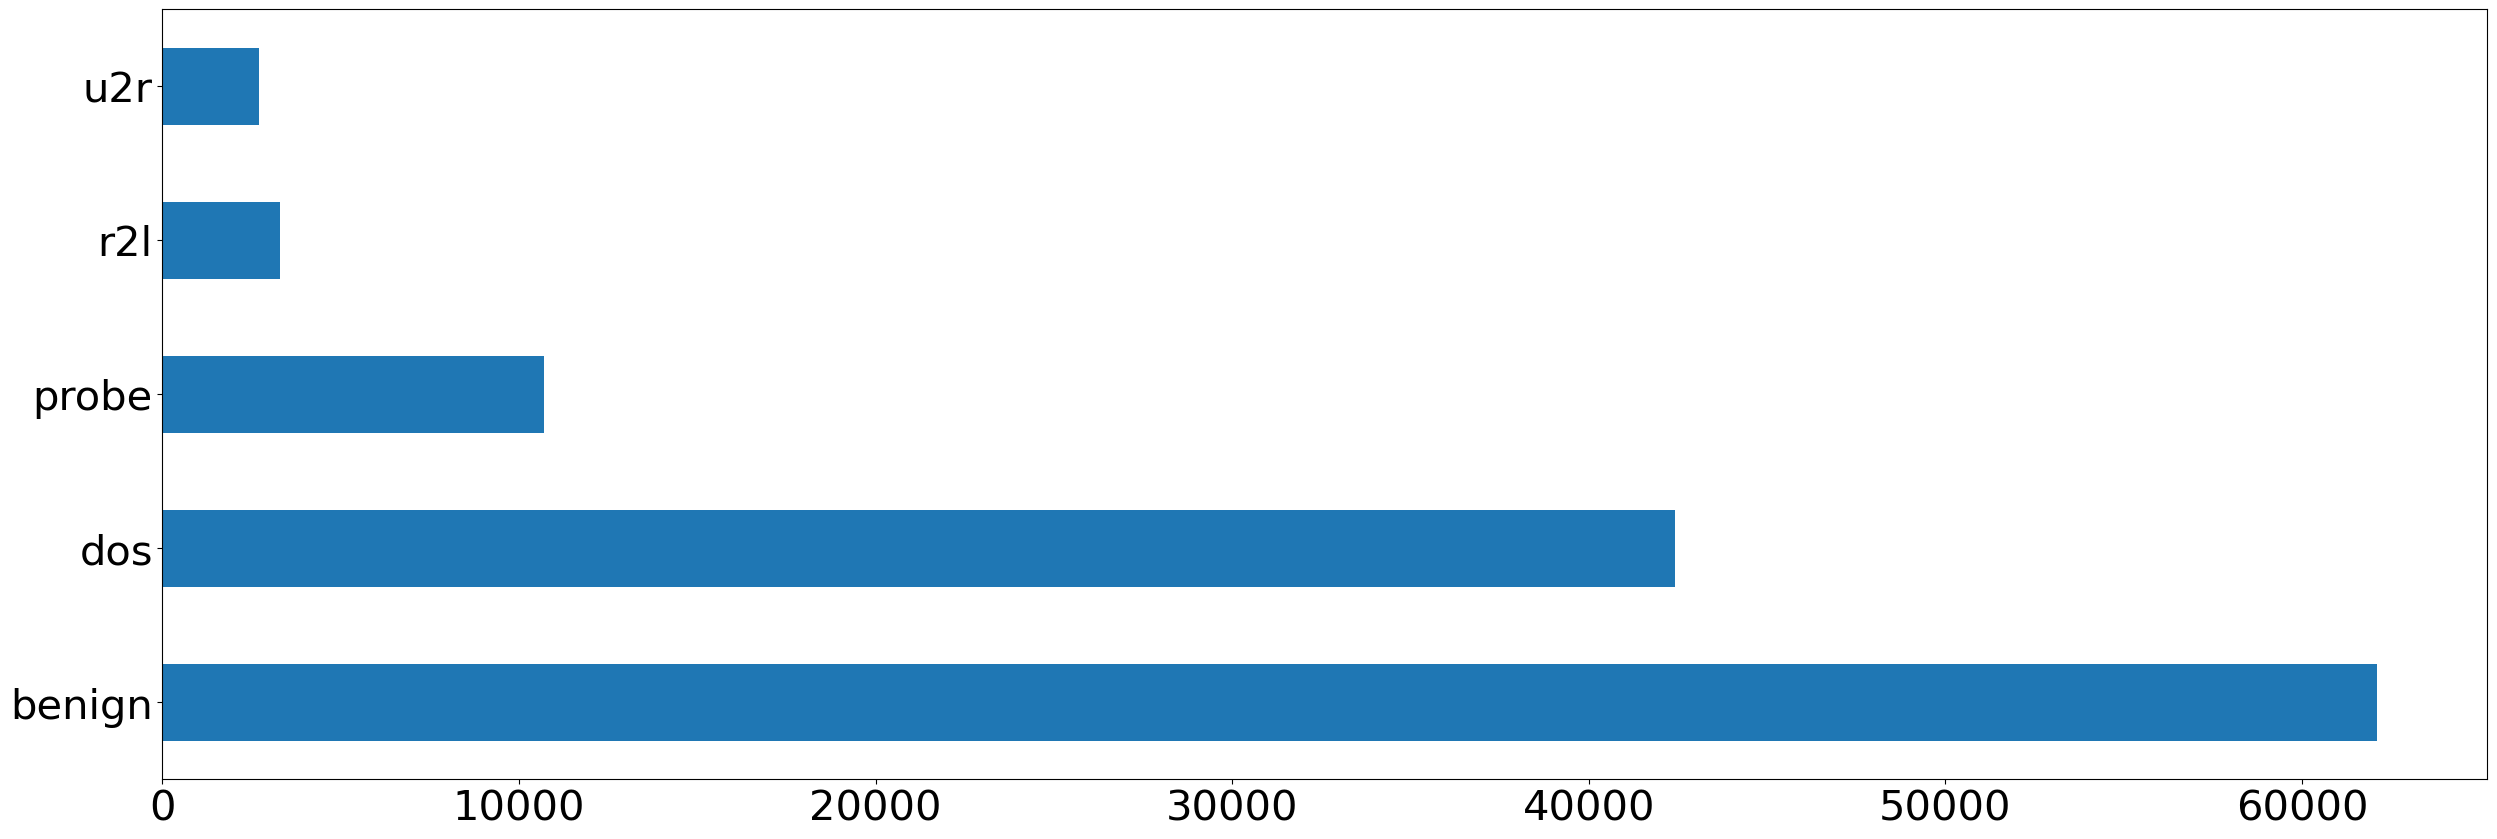

In [112]:
train_attack_types.plot(kind='barh', figsize=(30, 10), fontsize=30)
train_attack_cats.plot(kind='barh', figsize=(30, 10), fontsize=30)
test_attack_types.plot(kind='barh', figsize=(30, 10), fontsize=30)
test_attack_cats.plot(kind='barh', figsize=(30, 10), fontsize=30)

In [113]:
train_df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,116184.000000,1.161840e+05,1.161840e+05,116184.000000,116184.000000,116184.000000,116184.000000,116184.000000,116184.000000,116184.000000,...,116184.000000,116184.000000,116184.000000,116184.000000,116184.000000,116184.000000,116184.000000,116184.000000,116184.000000,116184.000000
mean,286.460881,3.668699e+04,2.114683e+04,0.000207,0.022757,0.000112,0.202885,0.001153,0.395674,0.274831,...,182.362089,115.679663,0.520776,0.083023,0.147965,0.032377,0.284614,0.278657,0.119066,0.120503
std,2596.720240,4.579381e+06,4.187174e+06,0.014371,0.254240,0.014669,2.137392,0.044478,0.488997,24.697912,...,99.123151,110.720057,0.448951,0.188980,0.308618,0.112283,0.444887,0.445767,0.306788,0.319745
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,63.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.750000e+02,5.150000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.000000,1.167519e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [114]:
train_x.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
count,1.161840e+05,1.161840e+05,1.161840e+05,116184.000000,1.161840e+05,1.161840e+05,1.161840e+05,1.161840e+05,116184.000000,1.161840e+05,...,116184.000000,116184.000000,116184.000000,116184.000000,116184.000000,116184.000000,116184.000000,116184.000000,116184.000000,116184.000000
mean,-7.950368e-19,-1.467760e-18,1.054953e-18,0.000207,5.137161e-18,-3.944606e-18,7.889211e-18,1.131399e-17,0.395674,-1.047308e-18,...,0.089462,0.012368,0.000818,0.019176,0.276931,0.002892,0.000998,0.000379,0.594566,0.002040
std,1.000004e+00,1.000004e+00,1.000004e+00,0.014371,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,0.488997,1.000004e+00,...,0.285410,0.110523,0.028583,0.137146,0.447484,0.053699,0.031582,0.019457,0.490978,0.045119
min,-1.103169e-01,-8.011376e-03,-5.050404e-03,0.000000,-8.951034e-02,-7.628038e-03,-9.492220e-02,-2.593067e-02,0.000000,-1.112776e-02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.103169e-01,-8.011376e-03,-5.050404e-03,0.000000,-8.951034e-02,-7.628038e-03,-9.492220e-02,-2.593067e-02,0.000000,-1.112776e-02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.103169e-01,-8.001768e-03,-5.050404e-03,0.000000,-8.951034e-02,-7.628038e-03,-9.492220e-02,-2.593067e-02,0.000000,-1.112776e-02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,-1.103169e-01,-7.951324e-03,-4.927408e-03,0.000000,-8.951034e-02,-7.628038e-03,-9.492220e-02,-2.593067e-02,1.000000,-1.112776e-02,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.641368e+01,2.549444e+02,3.128415e+02,1.000000,1.171042e+01,2.045130e+02,3.593044e+01,1.123893e+02,1.000000,3.028093e+02,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [115]:
train_x

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,-0.110317,-0.007904,-0.005050,0,-0.08951,-0.007628,-0.094922,-0.025931,0,-0.011128,...,0,0,0,0,0,0,0,0,1,0
1,-0.110317,-0.007979,-0.005050,0,-0.08951,-0.007628,-0.094922,-0.025931,0,-0.011128,...,0,0,0,0,0,0,0,0,1,0
2,-0.110317,-0.008011,-0.005050,0,-0.08951,-0.007628,-0.094922,-0.025931,0,-0.011128,...,0,0,0,0,1,0,0,0,0,0
3,-0.110317,-0.007961,-0.003103,0,-0.08951,-0.007628,-0.094922,-0.025931,1,-0.011128,...,0,0,0,0,0,0,0,0,1,0
4,-0.110317,-0.007968,-0.004950,0,-0.08951,-0.007628,-0.094922,-0.025931,1,-0.011128,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116179,-0.110317,-0.008011,-0.005050,0,-0.08951,-0.007628,-0.094922,-0.025931,0,-0.011128,...,1,0,0,0,0,0,0,0,0,0
116180,-0.110317,-0.007899,-0.005049,0,-0.08951,-0.007628,-0.094922,-0.025931,0,-0.011128,...,0,0,0,0,0,0,0,0,1,0
116181,-0.110317,-0.008011,-0.005050,0,-0.08951,-0.007628,-0.094922,-0.025931,0,-0.011128,...,0,0,0,0,1,0,0,0,0,0
116182,-0.110317,-0.008011,-0.005050,0,-0.08951,-0.007628,-0.094922,-0.025931,0,-0.011128,...,0,0,0,0,1,0,0,0,0,0


In [116]:
train_attack_cats

benign    62094
dos       42412
probe     10712
r2l         916
u2r          50
Name: attack_category, dtype: int64

In [117]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116184 entries, 0 to 116183
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     116184 non-null  int64  
 1   protocol_type                116184 non-null  object 
 2   service                      116184 non-null  object 
 3   flag                         116184 non-null  object 
 4   src_bytes                    116184 non-null  int64  
 5   dst_bytes                    116184 non-null  int64  
 6   land                         116184 non-null  int64  
 7   wrong_fragment               116184 non-null  int64  
 8   urgent                       116184 non-null  int64  
 9   hot                          116184 non-null  int64  
 10  num_failed_logins            116184 non-null  int64  
 11  logged_in                    116184 non-null  int64  
 12  num_compromised              116184 non-null  int64  
 13 

In [118]:
train_x.head(10)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,-0.110317,-0.007904,-0.005050,0,-0.08951,-0.007628,-0.094922,-0.025931,0,-0.011128,...,0,0,0,0,0,0,0,0,1,0
1,-0.110317,-0.007979,-0.005050,0,-0.08951,-0.007628,-0.094922,-0.025931,0,-0.011128,...,0,0,0,0,0,0,0,0,1,0
2,-0.110317,-0.008011,-0.005050,0,-0.08951,-0.007628,-0.094922,-0.025931,0,-0.011128,...,0,0,0,0,1,0,0,0,0,0
3,-0.110317,-0.007961,-0.003103,0,-0.08951,-0.007628,-0.094922,-0.025931,1,-0.011128,...,0,0,0,0,0,0,0,0,1,0
4,-0.110317,-0.007968,-0.004950,0,-0.08951,-0.007628,-0.094922,-0.025931,1,-0.011128,...,0,0,0,0,0,0,0,0,1,0
5,-0.110317,-0.008011,-0.005050,0,-0.08951,-0.007628,-0.094922,-0.025931,0,-0.011128,...,1,0,0,0,0,0,0,0,0,0
6,-0.110317,-0.008011,-0.005050,0,-0.08951,-0.007628,-0.094922,-0.025931,0,-0.011128,...,0,0,0,0,1,0,0,0,0,0
7,-0.110317,-0.008011,-0.005050,0,-0.08951,-0.007628,-0.094922,-0.025931,0,-0.011128,...,0,0,0,0,1,0,0,0,0,0
8,-0.110317,-0.008011,-0.005050,0,-0.08951,-0.007628,-0.094922,-0.025931,0,-0.011128,...,0,0,0,0,1,0,0,0,0,0
9,-0.110317,-0.008011,-0.005050,0,-0.08951,-0.007628,-0.094922,-0.025931,0,-0.011128,...,0,0,0,0,1,0,0,0,0,0


In [119]:
train_df.shape

(116184, 42)

In [120]:
train_df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_host_rate             0
dst_host_c

In [121]:
#Visualization
def bar_graph(feature):
    train_df[feature].value_counts().plot(kind="bar")

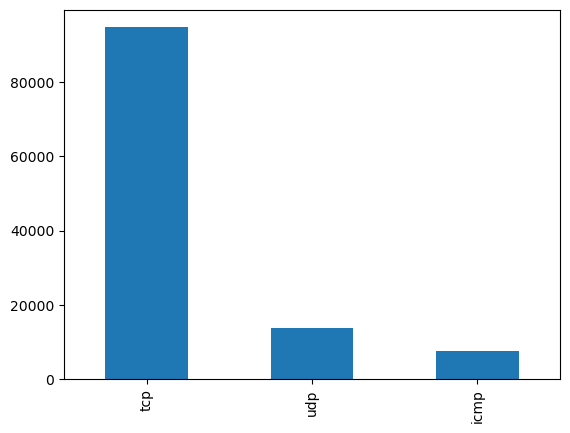

In [122]:
bar_graph('protocol_type')

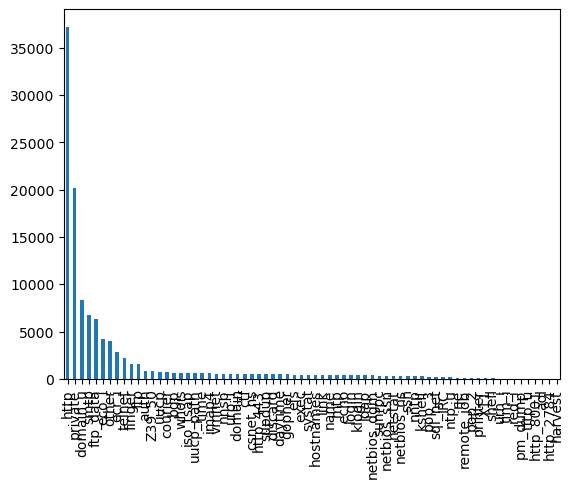

In [123]:
bar_graph('service')

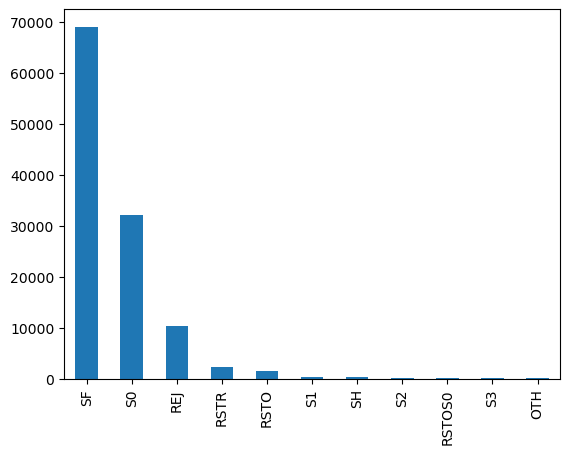

In [124]:
bar_graph('flag')

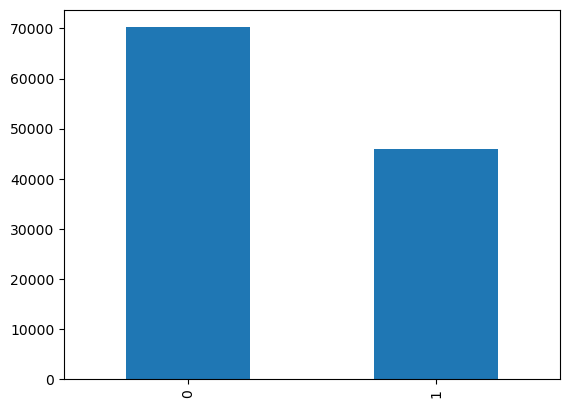

In [125]:
bar_graph('logged_in')

In [126]:
train_df.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'is_host_login', 'is_guest_login', 'count',
       'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
       'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
       'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
       'dst_host_serror_rate', 'dst_host_srv_serror_rate',
       'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type',
       'attack_category'],
      dtype='object')

In [127]:
train_x.columns

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       ...
       'flag_REJ', 'flag_RSTO', 'flag_RSTOS0', 'flag_RSTR', 'flag_S0',
       'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF', 'flag_SH'],
      dtype='object', length=118)

In [128]:
train_x['num_root'].corr(train_x['num_compromised'])

0.9990487970523759

In [129]:
train_x['srv_serror_rate'].corr(train_x['serror_rate'])

0.9933357110803614

In [130]:
train_x['srv_count'].corr(train_x['count'])

0.46971017920446745

In [131]:
train_x['srv_rerror_rate'].corr(train_x['rerror_rate'])

0.9891829262482821

In [132]:
train_x['dst_host_same_srv_rate'].corr(train_x['dst_host_srv_count'])

0.8975783571569705

In [133]:
train_x['dst_host_srv_serror_rate'].corr(train_x['dst_host_serror_rate'])

0.9851079260614719

In [134]:
train_df['dst_host_srv_rerror_rate'].corr(train_df['dst_host_rerror_rate'])

0.9249288428249035

In [135]:
train_df['num_root'].corr(train_df['num_compromised'])

0.9990487970523881

In [136]:
train_df['dst_host_same_srv_rate'].corr(train_df['same_srv_rate'])

0.78953469961604

In [137]:
train_df['dst_host_srv_count'].corr(train_df['same_srv_rate'])

0.7067178608147888

In [138]:
train_df['dst_host_same_src_port_rate'].corr(train_df['srv_count'])

0.15949713018368888

In [139]:
train_df['dst_host_serror_rate'].corr(train_df['serror_rate'])

0.9795568800811837

In [140]:
train_df['dst_host_serror_rate'].corr(train_df['srv_serror_rate'])

0.9777542423610911

In [141]:
train_df['dst_host_srv_serror_rate'].corr(train_df['serror_rate'])

0.981241549005847

In [142]:
train_df['dst_host_srv_serror_rate'].corr(train_df['srv_serror_rate'])

0.9863574751108809

In [143]:
train_df['dst_host_rerror_rate'].corr(train_df['rerror_rate'])

0.9267991341345155

In [144]:
train_df['dst_host_rerror_rate'].corr(train_df['srv_rerror_rate'])


0.9178963230785562

In [145]:
train_df['dst_host_srv_rerror_rate'].corr(train_df['rerror_rate'])

0.9644547735181772

In [146]:
train_df['dst_host_srv_rerror_rate'].corr(train_df['srv_rerror_rate'])

0.970052648335082

In [147]:
train_df.drop('num_root',axis = 1,inplace = True)
train_df.drop('srv_serror_rate',axis = 1,inplace = True)
train_df.drop('srv_rerror_rate',axis = 1, inplace=True)
train_df.drop('dst_host_srv_serror_rate',axis = 1, inplace=True)
train_df.drop('dst_host_serror_rate',axis = 1, inplace=True)
train_df.drop('dst_host_rerror_rate',axis = 1, inplace=True)
train_df.drop('dst_host_srv_rerror_rate',axis = 1, inplace=True)
train_df.drop('dst_host_same_srv_rate',axis = 1, inplace=True)

In [148]:
train_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,attack_type,attack_category
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,1.00,0.00,0.00,150,25,0.03,0.17,0.00,normal,benign
1,0,udp,other,SF,146,0,0,0,0,0,...,0.08,0.15,0.00,255,1,0.60,0.88,0.00,normal,benign
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.07,0.00,255,26,0.05,0.00,0.00,neptune,dos
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.00,30,255,0.00,0.03,0.04,normal,benign
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.09,255,255,0.00,0.00,0.00,normal,benign


In [149]:
train_df['protocol_type'].value_counts()

tcp     94736
udp     13851
icmp     7597
Name: protocol_type, dtype: int64

In [150]:
#protocol_type feature mapping
pmap = {'icmp':0,'tcp':1,'udp':2}
train_df['protocol_type'] = train_df['protocol_type'].map(pmap)

In [151]:
train_df['flag'].value_counts()

SF        69079
S0        32175
REJ       10394
RSTR       2228
RSTO       1437
S1          336
SH          237
S2          116
RSTOS0       95
S3           44
OTH          43
Name: flag, dtype: int64

In [152]:
fmap = {'SF':0,'S0':1,'REJ':2,'RSTR':3,'RSTO':4,'SH':5 ,'S1':6 ,'S2':7,'RSTOS0':8,'S3':9 ,'OTH':10}
train_df['flag'] = train_df['flag'].map(fmap)

In [153]:
train_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,attack_type,attack_category
0,0,1,ftp_data,0,491,0,0,0,0,0,...,1.00,0.00,0.00,150,25,0.03,0.17,0.00,normal,benign
1,0,2,other,0,146,0,0,0,0,0,...,0.08,0.15,0.00,255,1,0.60,0.88,0.00,normal,benign
2,0,1,private,1,0,0,0,0,0,0,...,0.05,0.07,0.00,255,26,0.05,0.00,0.00,neptune,dos
3,0,1,http,0,232,8153,0,0,0,0,...,1.00,0.00,0.00,30,255,0.00,0.03,0.04,normal,benign
4,0,1,http,0,199,420,0,0,0,0,...,1.00,0.00,0.09,255,255,0.00,0.00,0.00,normal,benign


In [154]:
train_df.drop('service',axis = 1,inplace= True)

In [155]:
train_df.shape

(116184, 33)

In [156]:
train_df.shape

(116184, 33)

In [157]:
# Data information
def data_exploration_solution():
    print("*******************")
    print("Step 4: Data Exploration (Understanding the data)")
    print("*******************")
    print("1. Identify the attribute names (Header)")
    print(train_df.columns)
    print("2. Check the length of the Train and Test dataset")
    print("length of Train dataset: ", train_df.shape)
    print("length of Test dataset: ", test_df.shape)
    print("3. Check the total number of samples that belong to each of the five classes of the training dataset.")
    print(train_df.groupby('attack_category')['flag'].count())


In [158]:
# Data information
data_exploration_solution()

*******************
Step 4: Data Exploration (Understanding the data)
*******************
1. Identify the attribute names (Header)
Index(['duration', 'protocol_type', 'flag', 'src_bytes', 'dst_bytes', 'land',
       'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
       'num_compromised', 'root_shell', 'su_attempted', 'num_file_creations',
       'num_shells', 'num_access_files', 'is_host_login', 'is_guest_login',
       'count', 'srv_count', 'serror_rate', 'rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
       'attack_type', 'attack_category'],
      dtype='object')
2. Check the length of the Train and Test dataset
length of Train dataset:  (116184, 33)
length of Test dataset:  (10015, 42)
3. Check the total number of samples that belong to each of the five classes of the training dataset.
attac

In [159]:
# Find best K value in KNN
def find_k():
    # find value for parameter n_neighbors value between 1 to 20 where accuracy is higher
    for i in range(1, 15):
        # KNN classifier
        clf_knn = KNeighborsClassifier(n_neighbors=i)

        # train data
        clf_knn = clf_knn.fit(train_x, train_Y)

        # predict
        pred_y = clf_knn.predict(test_x)

        print('accuracy for k value ', i, ': ', accuracy_score(test_Y, pred_y))

In [160]:
find_k()


accuracy for k value  1 :  0.9981028457314028
accuracy for k value  2 :  0.9974038941587619
accuracy for k value  3 :  0.9975037443834248
accuracy for k value  4 :  0.9969046430354468
accuracy for k value  5 :  0.9963055416874688
accuracy for k value  6 :  0.9963055416874688
accuracy for k value  7 :  0.9963055416874688
accuracy for k value  8 :  0.9963055416874688
accuracy for k value  9 :  0.9962056914628058
accuracy for k value  10 :  0.9959061407888168
accuracy for k value  11 :  0.9960059910134798
accuracy for k value  12 :  0.9963055416874688
accuracy for k value  13 :  0.9959061407888168
accuracy for k value  14 :  0.9959061407888168


In [161]:
# KNN classifier
def knn_clf():
    print(color.BOLD + color.GREEN + '***** KNN Classification ***** ' + color.END)

    # KNN classifier
    clf_knn = KNeighborsClassifier(n_neighbors=7)  # using 7 because it has higher accuray rate

    # start timer
    starttime = timeit.default_timer()

    print("***** Training the KNN Classifier ***** ")

    # Train model
    clf_knn = clf_knn.fit(train_x, train_Y)

    print("***** The time difference is :", timeit.default_timer() - starttime)

    print("***** Predicting test data ***** ")

    # predict
    pred_y = clf_knn.predict(test_x)

    # analyse results
    cm = confusion_matrix(test_Y, pred_y)  # confusion matrix
    error = zero_one_loss(test_Y, pred_y)  # error
    score = accuracy_score(test_Y, pred_y)

    # display results
    print('Confusion Matrix\n***** ***** ***** ***** \n', cm)
    print("Error: {:.4f}%".format(error * 100))
    print("Accuracy Score: {:.4f}%".format(score * 100))
    print(classification_report(test_Y, pred_y))
    print('accuracy: ', cm.diagonal() / cm.sum(axis=1))
    
    
    # Plot non-normalized confusion matrix
    #cm = confusion_matrix(test_Y, pred_y, labels=None)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
        
    disp.plot(include_values=True, cmap='viridis', xticks_rotation='horizontal', values_format=None, ax=None, colorbar=True, im_kw=None)
    plt.title("Confusion Matrix for k-nearest neighbors")

    plt.show()


***** KNN Classification ***** 
***** Training the KNN Classifier ***** 
***** The time difference is : 0.2424553000000742
***** Predicting test data ***** 
Confusion Matrix
***** ***** ***** ***** 
 [[5349    5    4    4    0]
 [   6 3588    0    0    0]
 [  13    0  959    0    0]
 [   4    0    0   81    0]
 [   1    0    0    0    1]]
Error: 0.3694%
Accuracy Score: 99.6306%
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00      5362
         dos       1.00      1.00      1.00      3594
       probe       1.00      0.99      0.99       972
         r2l       0.95      0.95      0.95        85
         u2r       1.00      0.50      0.67         2

    accuracy                           1.00     10015
   macro avg       0.99      0.89      0.92     10015
weighted avg       1.00      1.00      1.00     10015

accuracy:  [0.99757553 0.99833055 0.98662551 0.95294118 0.5       ]


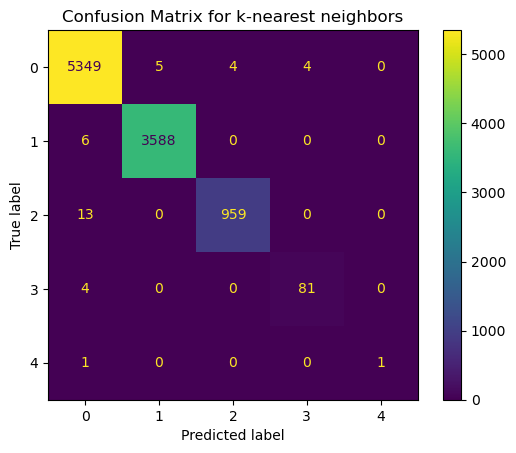

In [162]:
knn_clf()

In [163]:
# Decision Tree
def decision_tree_clf():
    print(color.BOLD + color.RED + '***** Decision Tree Classification ***** ' + color.END)

    # build Decision Tree classifier
    classifier = DecisionTreeClassifier(random_state=17)

    # Train Classifier
    classifier.fit(train_x, train_Y)

    # predict
    pred_y = classifier.predict(test_x)

    # confusion matrix
    cm = confusion_matrix(test_Y, pred_y)

    # error rate
    error = zero_one_loss(test_Y, pred_y)
    score = accuracy_score(test_Y, pred_y)
    
    # print results
    print('Confusion Matrix\n***** ***** \n', cm)
    print("Error: {:.4f}%".format(error * 100))
    print("Accuracy Score: {:.4f}%".format(score * 100))
    print(classification_report(test_Y, pred_y))
    print('accuracy: ', cm.diagonal() / cm.sum(axis=1))
    
    
    # Plot non-normalized confusion matrix
    #cm = confusion_matrix(test_Y, pred_y, labels=None)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
        
    disp.plot(include_values=True, cmap='viridis', xticks_rotation='horizontal', values_format=None, ax=None, colorbar=True, im_kw=None)
    plt.title("Confusion Matrix for Decision Tree")

    plt.show()

***** Decision Tree Classification ***** 
Confusion Matrix
***** ***** 
 [[5355    0    5    0    2]
 [   2 3592    0    0    0]
 [   5    1  966    0    0]
 [   0    0    0   85    0]
 [   0    0    0    0    2]]
Error: 0.1498%
Accuracy Score: 99.8502%
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00      5362
         dos       1.00      1.00      1.00      3594
       probe       0.99      0.99      0.99       972
         r2l       1.00      1.00      1.00        85
         u2r       0.50      1.00      0.67         2

    accuracy                           1.00     10015
   macro avg       0.90      1.00      0.93     10015
weighted avg       1.00      1.00      1.00     10015

accuracy:  [0.99869452 0.99944352 0.99382716 1.         1.        ]


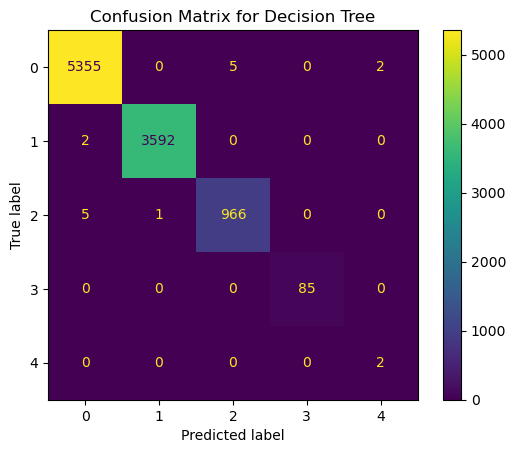

In [164]:
# Decision Tree
decision_tree_clf()

In [165]:
# Multi-Layer Percepton MLP
def mlp_clf():
    print(color.BOLD + color.PURPLE + "       *****  ANN Classification *****       " + color.END)
    # Build classifier
    clf_nn = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(10, 5), max_iter=100, random_state=1)

    print("***** Training the MLP Classifier ***** ")

    # start timer
    starttime = timeit.default_timer()  # start timer

    # training model
    clf_nn.fit(train_x, train_Y)

    print("The time difference is :", timeit.default_timer() - starttime)

    print("Predicting test data ***** ")

    # predict
    nn_pred = clf_nn.predict(test_x)

    # results
    cm = confusion_matrix(test_Y, nn_pred)
    error = zero_one_loss(test_Y, nn_pred)
    score = accuracy_score(test_Y, nn_pred)

    # display results
    print('Confusion Matrix\n***** ***** \n', cm)
    print('***** ***** ***** ***** ***** ')
    print("Error: {:.4f}%".format(error * 100))
    print("Accuracy Score: {:.4f}%".format(score * 100))
    print(classification_report(test_Y, nn_pred))
    print('accuracy: ', cm.diagonal() / cm.sum(axis=1))

    # Plot non-normalized confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
        
    disp.plot(include_values=True, cmap='viridis', xticks_rotation='horizontal', values_format=None, ax=None, colorbar=True, im_kw=None)
    plt.title("Confusion Matrix for Neural Network")

    plt.show()

       *****  ANN Classification *****       
***** Training the MLP Classifier ***** 
The time difference is : 56.84212530000002
Predicting test data ***** 
Confusion Matrix
***** ***** 
 [[5344    1    6   11    0]
 [   5 3589    0    0    0]
 [   5    0  967    0    0]
 [   4    0    0   81    0]
 [   2    0    0    0    0]]
***** ***** ***** ***** ***** 
Error: 0.3395%
Accuracy Score: 99.6605%
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00      5362
         dos       1.00      1.00      1.00      3594
       probe       0.99      0.99      0.99       972
         r2l       0.88      0.95      0.92        85
         u2r       0.00      0.00      0.00         2

    accuracy                           1.00     10015
   macro avg       0.77      0.79      0.78     10015
weighted avg       1.00      1.00      1.00     10015

accuracy:  [0.99664304 0.99860879 0.99485597 0.95294118 0.        ]


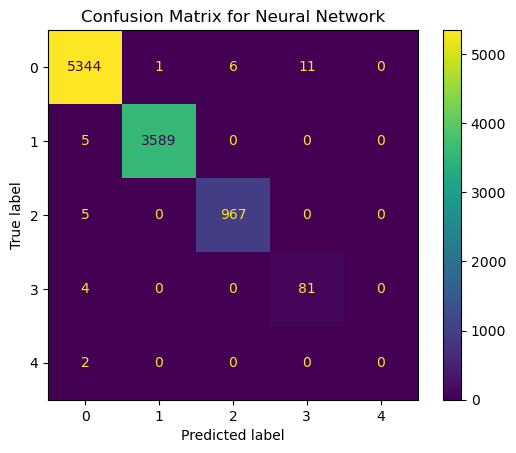

In [166]:
mlp_clf()

In [167]:
train_x

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,-0.110317,-0.007904,-0.005050,0,-0.08951,-0.007628,-0.094922,-0.025931,0,-0.011128,...,0,0,0,0,0,0,0,0,1,0
1,-0.110317,-0.007979,-0.005050,0,-0.08951,-0.007628,-0.094922,-0.025931,0,-0.011128,...,0,0,0,0,0,0,0,0,1,0
2,-0.110317,-0.008011,-0.005050,0,-0.08951,-0.007628,-0.094922,-0.025931,0,-0.011128,...,0,0,0,0,1,0,0,0,0,0
3,-0.110317,-0.007961,-0.003103,0,-0.08951,-0.007628,-0.094922,-0.025931,1,-0.011128,...,0,0,0,0,0,0,0,0,1,0
4,-0.110317,-0.007968,-0.004950,0,-0.08951,-0.007628,-0.094922,-0.025931,1,-0.011128,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116179,-0.110317,-0.008011,-0.005050,0,-0.08951,-0.007628,-0.094922,-0.025931,0,-0.011128,...,1,0,0,0,0,0,0,0,0,0
116180,-0.110317,-0.007899,-0.005049,0,-0.08951,-0.007628,-0.094922,-0.025931,0,-0.011128,...,0,0,0,0,0,0,0,0,1,0
116181,-0.110317,-0.008011,-0.005050,0,-0.08951,-0.007628,-0.094922,-0.025931,0,-0.011128,...,0,0,0,0,1,0,0,0,0,0
116182,-0.110317,-0.008011,-0.005050,0,-0.08951,-0.007628,-0.094922,-0.025931,0,-0.011128,...,0,0,0,0,1,0,0,0,0,0


In [168]:
df1 = df.copy()
df1 = df1.select_dtypes(exclude=['object'])

In [169]:
df.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,occurance
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [170]:
df1.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,occurance
0,0,491,0,0,0,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,20
1,0,146,0,0,0,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,15
2,0,0,0,0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,19
3,0,232,8153,0,0,0,0,0,1,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,21
4,0,199,420,0,0,0,0,0,1,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21


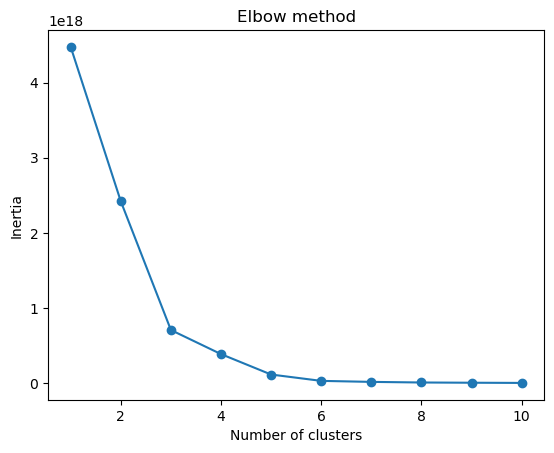

In [171]:
from sklearn.cluster import KMeans
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df1)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [172]:
df1

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,occurance
0,0,491,0,0,0,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,20
1,0,146,0,0,0,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,15
2,0,0,0,0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,19
3,0,232,8153,0,0,0,0,0,1,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,21
4,0,199,420,0,0,0,0,0,1,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116179,0,0,0,0,0,0,0,0,0,0,...,1,0.00,1.00,0.00,0.00,0.22,0.00,0.78,1.00,20
116180,0,516,4,0,0,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,17
116181,0,0,0,0,0,0,0,0,0,0,...,25,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,20
116182,0,0,0,0,0,0,0,0,0,0,...,9,0.04,0.07,0.00,0.00,1.00,1.00,0.00,0.00,21


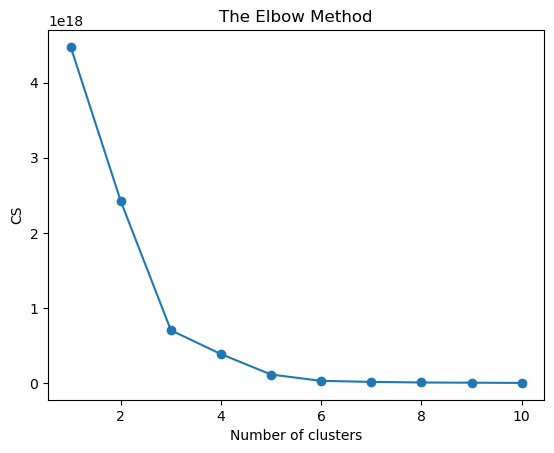

In [173]:
from sklearn.cluster import KMeans
cs = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(df1)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 11), cs,marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

In [174]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,occurance
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [175]:
train_df.head()

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,attack_type,attack_category
0,0,1,0,491,0,0,0,0,0,0,...,1.00,0.00,0.00,150,25,0.03,0.17,0.00,normal,benign
1,0,2,0,146,0,0,0,0,0,0,...,0.08,0.15,0.00,255,1,0.60,0.88,0.00,normal,benign
2,0,1,1,0,0,0,0,0,0,0,...,0.05,0.07,0.00,255,26,0.05,0.00,0.00,neptune,dos
3,0,1,0,232,8153,0,0,0,0,0,...,1.00,0.00,0.00,30,255,0.00,0.03,0.04,normal,benign
4,0,1,0,199,420,0,0,0,0,0,...,1.00,0.00,0.09,255,255,0.00,0.00,0.00,normal,benign


In [176]:
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,occurance
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116179,0,tcp,other,REJ,0,0,0,0,0,0,...,0.00,1.00,0.00,0.00,0.22,0.00,0.78,1.00,satan,20
116180,0,udp,other,SF,516,4,0,0,0,0,...,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,normal,17
116181,0,tcp,finger,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20
116182,0,tcp,netbios_ssn,S0,0,0,0,0,0,0,...,0.04,0.07,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21


In [177]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2,random_state=0)
y = df['attack_type']
kmeans.fit(df1)

labels = kmeans.labels_

# check how many of the samples were correctly labeled

correct_labels = sum(y == labels)

print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))

print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))

Result: 0 out of 116184 samples were correctly labeled.
Accuracy score: 0.00


In [178]:
kmeans.cluster_centers_

array([[2.85841334e+02, 1.53207275e+04, 2.11473730e+04, 2.06574225e-04,
        2.27575938e-02, 1.11894372e-04, 2.02881710e-01, 1.15337275e-03,
        3.95684320e-01, 2.74838399e-01, 1.29969616e-03, 1.05869290e-03,
        2.95504428e-01, 1.23686317e-02, 4.38970227e-04, 4.04541190e-03,
        0.00000000e+00, 8.60725936e-06, 9.40773448e-03, 8.42787805e+01,
        2.77751956e+01, 2.84581902e-01, 2.82552999e-01, 1.20147270e-01,
        1.21433195e-01, 6.60360300e-01, 6.33484821e-02, 9.70777494e-02,
        1.82363278e+02, 1.15682607e+02, 5.20788855e-01, 8.30229556e-02,
        1.47965416e-01, 3.23782718e-02, 2.84619774e-01, 2.78658903e-01,
        1.19067920e-01, 1.20486482e-01, 1.95064339e+01],
       [2.42796667e+04, 8.27487933e+08, 0.00000000e+00, 2.71050543e-20,
        0.00000000e+00, 0.00000000e+00, 3.33333333e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.16840434e-19,
        0.00000000e+00, 0.00000000e+00, 5.42101086e-20, 8.67361738e-19,
       

In [185]:
y = train_df['attack_type'] # lable

In [186]:
#train_df1 = y

In [187]:
# Multi-Layer Percepton MLP
def k_mean():
    print(color.BOLD + color.PURPLE + "       ***** K-MEANS CLUSTTERING *****      " + color.END)
    # Build classifier
    
    print(" ***** Training the K-MEANS CLUSTTERING *****")
    
    from sklearn.cluster import KMeans
    
    # start timer
    starttime = timeit.default_timer()  # start timer
    cs = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 1000, n_init = 10, random_state = 0)
        kmeans.fit(df1)
        cs.append(kmeans.inertia_)
        
    plt.plot(range(1, 11), cs,marker='o')
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.show()

    print("The time difference is :", timeit.default_timer() - starttime)

       ***** K-MEANS CLUSTTERING *****      
 ***** Training the K-MEANS CLUSTTERING *****


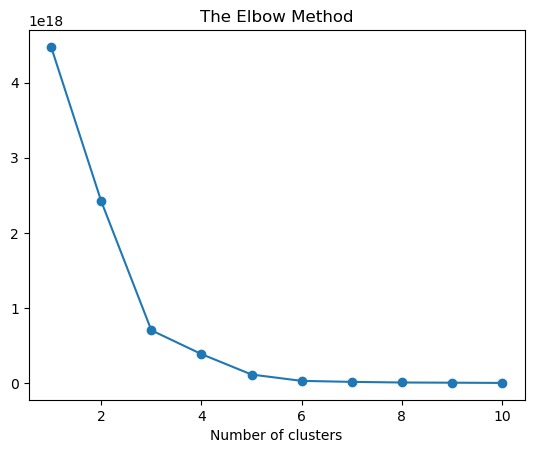

The time difference is : 9.921611500000154


In [188]:
k_mean()